<a href="https://colab.research.google.com/github/edgarcipn1/UNIR/blob/main/Incidentes_viales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencias

In [ ]:
!pip install varclushi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from scipy import stats
from varclushi import VarClusHi

from functools import reduce

from datetime import datetime,date
from dateutil.relativedelta import relativedelta as rd

import os

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression

import pickle

cf.go_offline()
pd.set_option('display.max_columns', None)

In [ ]:
def normalizar(df,var:str,umbral:float=0.05)->tuple:
    """Esta función normaliza una variable discreta basada en el
    principio de umbral de representatividad estadística.

    Args:
        df (pd.DataFrame): datos con v.d. a normalizar
        var (str): nombre de la variable
        umbral (float, optional): umbral estadístico deseado. Defaults to 0.05.

    Returns:
        tuple: nombre de la variable y mapa de normalización
    """
    aux = df[var].value_counts(1).to_frame()
    aux.columns = [var]
    aux['map'] = np.where(aux[var]<umbral,'Otros',aux.index)
    if aux.loc[aux['map']=='Otros'][var].sum()<umbral:
        aux['map'].replace({'Otros':aux.head(1)['map'].values[0]},inplace=True)
    aux.drop(var,axis=1,inplace=True)
    return var,aux['map'].to_dict()

def freq(df,var:list):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().sort_index()
        aux.columns = ['FA']
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.cumsum()
        print(f'****Tabla de frecuencias  {v}  ***\n\n')
        print(aux)
        print("\n"*3)


## Lectura de datos

In [ ]:
ruta = "/content/nuevo_acumulado_hechos_de_transito_2023_12.csv"
#"https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5/resource/59d5ede6-7af8-4384-a114-f84ff1b26fe1"
#ruta = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/02.  Para Ingeniería/incidentes viales SSC/inViales_2022_2023.csv'

In [ ]:
df = pd.read_csv(ruta)

<ipython-input-5-b914caaa4bbe>:1: DtypeWarning:

Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
df.head()

,fecha_evento,hora_evento,tipo_evento,fecha_captura,folio,latitud,longitud,punto_1,punto_2,colonia,alcaldia,zona_vial,sector,unidad_a_cargo,tipo_de_interseccion,interseccion_semaforizada,clasificacion_de_la_vialidad,sentido_de_circulacion,dia,prioridad,origen,unidad_medica_de_apoyo,matricula_unidad_medica,trasladado_lesionados,personas_fallecidas,personas_lesionadas
0,2020-04-06,12:50:00,CHOQUE,2020-04-17,BJ/200406/03499,19.368116,-99.142903,EJE 7 SUR,ANTILLAS,PORTALES NTE,BENITO JUAREZ,4,PORTALES,MX164B4,CRUZ,NO,EJE VIAL,P-O,Lunes,BAJA,RADIO,PC,NaN,NO,0,1
1,2020-04-06,18:31:00,CHOQUE,2020-04-17,C5/200406/05748,19.301142,-99.115521,CALZ DEL HUESO,RANCHO COLORADO,COAPA STA CECILIA,COYOACAN,4,CULHUACAN,MX337S2,CRUZ,NO,VIA PRIMARIA,O-P,Lunes,BAJA,911 CDMX,ERUM,NaN,NO,0,1
2,2020-04-06,18:39:00,CHOQUE,2020-04-17,C5/200406/05802,19.476843,-99.092207,EJE 5 NTE,AV GRAN CANAL DEL DESAGUE,JOSE MA MORELOS Y PAVON,GUSTAVO A MADERO,1,PRADERA,MX329N2,T,SI,EJE VIAL,P-O,Lunes,BAJA,911 CDMX,PARTICULAR,NaN,NO,0,1
3,2020-04-06,11:38:00,DERRAPADO,2020-04-17,IZ/200406/03058,19.298474,-98.984670,EJE 10 SUR,AV SAN FCO,SAN FCO TLALTENCO,TLAHUAC,3,MIXQUIC,SD,RECTA,NO,EJE VIAL,NO-SP,Lunes,MEDIA,RADIO,PC,NaN,SI,0,1
4,2020-04-06,13:31:00,DERRAPADO,2020-04-17,C5/200406/03762,19.436170,-99.204754,AV HOMERO,SOFOCLES,LOS MORALES,MIGUEL HIDALGO,5,POLANCO CASTILLO,MX606D2,CRUZ,SI,VIA PRIMARIA,P-O,Lunes,BAJA,911 CDMX,SEGURO,NaN,NO,0,1


In [ ]:

columnas = ['fecha_evento','hora','tipo_de_evento','coordenada','tipo_de_interseccion',
'tipo_de_vehiculo_1','tipo_de_vehiculo_2','edad_lesionado','prioridad','interseccion_semaforizada','clasificacion_de_la_vialidad','alcaldia']
df = pd.read_csv(ruta, usecols=columnas)
df = df[~df['hora'].isnull()].reset_index(drop=True)

ValueError: Usecols do not match columns, columns expected but not found: ['tipo_de_vehiculo_2', 'edad_lesionado', 'fecha_evento', 'tipo_de_evento', 'prioridad', 'clasificacion_de_la_vialidad', 'alcaldia', 'tipo_de_interseccion', 'coordenada', 'interseccion_semaforizada', 'hora', 'tipo_de_vehiculo_1']

In [ ]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
109656    False
109657    False
109658    False
109659    False
109660    False
Length: 109661, dtype: bool

In [ ]:
df[df.duplicated()]

,fecha_evento,hora,tipo_de_evento,alcaldia,tipo_de_interseccion,tipo_de_vehiculo_1,tipo_de_vehiculo_2,edad_lesionado,prioridad,coordenada,interseccion_semaforizada,clasificacion_de_la_vialidad
20430,2018-09-01,03:28:00,DERRAPADO,CUAUHTEMOC,CRUZ,MOTOCICLETA,NaN,28,BAJA,"19.430179,-99.148242",NaN,NaN
34135,2018-09-01,08:12:00,CHOQUE,IZTAPALAPA,CRUZ,AUTOMOVIL,AUTOMOVIL,31,BAJA,"19.384,-99.075775",NaN,NaN
56173,2021-04-02,08:39:00,DERRAPADO,COYOACAN,CRUZ,MOTOCICLETA,NaN,48 39,BAJA,"19.336950,-99.147219",SI,VIA PRIMARIA
80131,2022-03-16,07:32:00,CHOQUE,CUAUHTEMOC,CRUZ,AUTOMOVIL,AUTOMOVIL,14,BAJA,NaN,NO,VIA SECUNDARIA
99983,2022-10-01,10:53:00,CHOQUE,IZTACALCO,RECTA,MICROBUS,CAMION DE CARGA,26 32 67,BAJA,NaN,NO,VIA PRIMARIA
99984,2022-10-01,14:48:00,CHOQUE,VENUSTIANO CARRANZA,RECTA,CAMION DE CARGA,AUTOBUS DE PASAJEROS,44,BAJA,NaN,NO,EJE VIAL
99985,2022-10-01,16:09:00,CHOQUE,IZTAPALAPA,CURVA,MOTOCICLETA,CAMION DE CARGA,NaN,ALTA,NaN,NO,EJE VIAL
99986,2022-10-01,11:52:00,VOLCADURA,GUSTAVO A MADERO,RECTA,MICROBUS,NaN,16 16 27 28 37 38 38 38 38 39 46 52 53 64 67,ALTA,NaN,SI,VIA PRIMARIA
99987,2022-10-03,13:49:00,CHOQUE,CUAUHTEMOC,RECTA,CAMIONETA,METROBUS,45,BAJA,NaN,NO,VIA SECUNDARIA
99988,2022-10-03,17:09:00,CHOQUE,TLAHUAC,RECTA,MOTOCICLETA,CAMION DE CARGA,22,ALTA,NaN,SI,VIA SECUNDARIA


In [ ]:
# df['ts'] = pd.to_datetime(df[['fecha_evento','hora']].apply(" ".join,axis=1))
# df.drop(['fecha_evento','hora'],axis=1,inplace=True)
# df.head()

In [ ]:
#df.to_parquet('incidentes.parquet')

In [ ]:
def getHora(hora):
    if 0<=hora<=6:
        return "01. Madrugada"
    elif 6<hora<=12:
        return "02. Mañana"
    elif 12<hora<=18:
        return "03. Tarde"
    elif 18<hora:
        return "04. Noche"

In [ ]:
df['fecha_evento'] = pd.to_datetime(df['fecha_evento'], format='%Y-%m-%d').dt.date
df = df[df['fecha_evento']<date(2023,1,1)].reset_index(drop=True)
df['hora'] = df['hora'].map(lambda x:x[:2]).astype(int).map(getHora)
df['mes'] = df['fecha_evento'].map(lambda x:x.strftime('%m')).astype(int)

In [ ]:
var_disc_trat = ['tipo_de_evento','tipo_de_interseccion','tipo_de_vehiculo_1','tipo_de_vehiculo_2',
'prioridad','interseccion_semaforizada','clasificacion_de_la_vialidad']

In [ ]:
for v  in var_disc_trat:
    df[v] = df[v].fillna('MISSING').astype(str).map(str.upper)

In [ ]:
mapa_norm = list(map(lambda v:normalizar(df,v,0.05),var_disc_trat))

In [ ]:
mapa_norm

[('tipo_de_evento',
  {'CHOQUE': 'CHOQUE',
   'ATROPELLADO': 'ATROPELLADO',
   'DERRAPADO': 'DERRAPADO',
   'CAIDA DE CICLISTA': 'Otros',
   'VOLCADURA': 'Otros',
   'CAIDA DE PASAJERO': 'Otros'}),
 ('tipo_de_interseccion',
  {'CRUZ': 'CRUZ',
   'T': 'T',
   'RECTA': 'RECTA',
   'Y': 'Otros',
   'RAMAS MULTIPLES': 'Otros',
   'CURVA': 'Otros',
   'GLORIETA': 'Otros',
   'DESNIVEL': 'Otros',
   'GAZA': 'Otros',
   'RECTA DESNIVEL': 'Otros'}),
 ('tipo_de_vehiculo_1',
  {'MOTOCICLETA': 'MOTOCICLETA',
   'AUTOMOVIL': 'AUTOMOVIL',
   'BICICLETA': 'BICICLETA',
   'SD': 'Otros',
   'TAXI': 'Otros',
   'CAMIONETA': 'Otros',
   'CAMION DE CARGA': 'Otros',
   'AUTOBUS DE PASAJEROS': 'Otros',
   'MICROBUS': 'Otros',
   'METROBUS': 'Otros',
   'TROLEBUS': 'Otros',
   'MONOPATIN': 'Otros',
   'TREN LIGERO': 'Otros',
   'TREN': 'Otros',
   'TREN SUBURBANO': 'Otros',
   'FERROCARRIL': 'Otros'}),
 ('tipo_de_vehiculo_2',
  {'MISSING': 'MISSING',
   'AUTOMOVIL': 'AUTOMOVIL',
   'MOTOCICLETA': 'MOTOCICLE

In [ ]:
varn = []
for v,mapa in mapa_norm:
    var = f'n_{v}'
    df[var] = df[v].replace(mapa)
    varn.append(var)

In [ ]:
freq(df,varn)

****Tabla de frecuencias  n_tipo_de_evento  ***


                FA        FR     FAA       FRA
ATROPELLADO  20279  0.193047   20279  0.193047
CHOQUE       59324  0.564738   79603  0.757785
DERRAPADO    19619  0.186764   99222  0.944549
Otros         5825  0.055451  105047  1.000000




****Tabla de frecuencias  n_tipo_de_interseccion  ***


          FA        FR     FAA       FRA
CRUZ   50449  0.480252   50449  0.480252
Otros  10799  0.102802   61248  0.583053
RECTA  11684  0.111226   72932  0.694280
T      32115  0.305720  105047  1.000000




****Tabla de frecuencias  n_tipo_de_vehiculo_1  ***


                FA        FR     FAA       FRA
AUTOMOVIL    32757  0.311832   32757  0.311832
BICICLETA     6253  0.059526   39010  0.371358
MOTOCICLETA  47212  0.449437   86222  0.820795
Otros        18825  0.179205  105047  1.000000




****Tabla de frecuencias  n_tipo_de_vehiculo_2  ***


                FA        FR     FAA       FRA
AUTOMOVIL    27627  0.262997   27627  0.262997
MISSI

In [ ]:
df['fecha_evento'].map(lambda x:x.strftime('%Y-%m')).value_counts().sort_index().iplot(kind='lines', color='purple')

## Ingeniería de características

In [ ]:
df

,fecha_evento,hora,tipo_de_evento,alcaldia,tipo_de_interseccion,tipo_de_vehiculo_1,tipo_de_vehiculo_2,edad_lesionado,prioridad,coordenada,interseccion_semaforizada,clasificacion_de_la_vialidad,mes,n_tipo_de_evento,n_tipo_de_interseccion,n_tipo_de_vehiculo_1,n_tipo_de_vehiculo_2,n_prioridad,n_interseccion_semaforizada,n_clasificacion_de_la_vialidad
0,2020-04-06,02. Mañana,CHOQUE,BENITO JUAREZ,CRUZ,AUTOMOVIL,BICICLETA,17,BAJA,"19.368116,-99.142903",NO,EJE VIAL,4,CHOQUE,CRUZ,AUTOMOVIL,Otros,BAJA,NO,EJE VIAL
1,2020-04-06,03. Tarde,CHOQUE,COYOACAN,CRUZ,MOTOCICLETA,AUTOMOVIL,34,BAJA,"19.301142,-99.115521",NO,VIA PRIMARIA,4,CHOQUE,CRUZ,MOTOCICLETA,AUTOMOVIL,BAJA,NO,VIA PRIMARIA
2,2020-04-06,03. Tarde,CHOQUE,GUSTAVO A MADERO,T,MOTOCICLETA,AUTOMOVIL,30,BAJA,"19.476843,-99.092207",SI,EJE VIAL,4,CHOQUE,T,MOTOCICLETA,AUTOMOVIL,BAJA,SI,EJE VIAL
3,2020-04-06,02. Mañana,DERRAPADO,TLAHUAC,RECTA,MOTOCICLETA,MISSING,27,MEDIA,"19.298474,-98.98467",NO,EJE VIAL,4,DERRAPADO,RECTA,MOTOCICLETA,MISSING,MEDIA,NO,EJE VIAL
4,2020-04-06,03. Tarde,DERRAPADO,MIGUEL HIDALGO,CRUZ,MOTOCICLETA,MISSING,39,BAJA,"19.43617,-99.204754",SI,VIA PRIMARIA,4,DERRAPADO,CRUZ,MOTOCICLETA,MISSING,BAJA,SI,VIA PRIMARIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105042,2022-12-31,03. Tarde,DERRAPADO,IZTAPALAPA,T,MOTOCICLETA,MISSING,25,BAJA,NaN,NO,EJE VIAL,12,DERRAPADO,T,MOTOCICLETA,MISSING,BAJA,NO,EJE VIAL
105043,2022-12-31,03. Tarde,DERRAPADO,COYOACAN,CRUZ,MOTOCICLETA,MISSING,43,MEDIA,NaN,SI,EJE VIAL,12,DERRAPADO,CRUZ,MOTOCICLETA,MISSING,MEDIA,SI,EJE VIAL
105044,2022-12-31,04. Noche,DERRAPADO,IZTAPALAPA,T,MOTOCICLETA,MISSING,NaN,ALTA,NaN,SI,VAC ANULAR,12,DERRAPADO,T,MOTOCICLETA,MISSING,BAJA,SI,VAC ANULAR
105045,2022-12-31,04. Noche,DERRAPADO,BENITO JUAREZ,CRUZ,MOTOCICLETA,MISSING,30,MEDIA,NaN,NO,VAC RADIAL,12,DERRAPADO,CRUZ,MOTOCICLETA,MISSING,MEDIA,NO,Otros


In [ ]:
um = ['alcaldia','n_tipo_de_evento']

In [ ]:
df['mes']  = df['fecha_evento'].map(lambda x:x.strftime('%Y-%m'))

In [ ]:
df['mes']

0         2020-04
1         2020-04
2         2020-04
3         2020-04
4         2020-04
           ...   
105042    2022-12
105043    2022-12
105044    2022-12
105045    2022-12
105046    2022-12
Name: mes, Length: 105047, dtype: object

In [ ]:
vobs=6
vpred=1
sub = 2

### Catálogo de fechas

In [ ]:
catfh = df[['mes']].drop_duplicates().copy().sort_values(by='mes').reset_index(drop=True)
catfh.insert(0,'id',catfh.index+1)

In [ ]:
anclai,anclaf = catfh['id'].min()+vobs-1,catfh['id'].max()-vpred
anclai,anclaf

(6, 59)

In [ ]:
df = df.merge(catfh,on='mes',how='inner').drop('mes',axis=1)

In [ ]:
df.to_csv('clean_done.csv')

In [ ]:
df.head()

,fecha_evento,hora,tipo_de_evento,alcaldia,tipo_de_interseccion,tipo_de_vehiculo_1,tipo_de_vehiculo_2,edad_lesionado,prioridad,coordenada,interseccion_semaforizada,clasificacion_de_la_vialidad,n_tipo_de_evento,n_tipo_de_interseccion,n_tipo_de_vehiculo_1,n_tipo_de_vehiculo_2,n_prioridad,n_interseccion_semaforizada,n_clasificacion_de_la_vialidad,id
0,2020-04-06,02. Mañana,CHOQUE,BENITO JUAREZ,CRUZ,AUTOMOVIL,BICICLETA,17,BAJA,"19.368116,-99.142903",NO,EJE VIAL,CHOQUE,CRUZ,AUTOMOVIL,Otros,BAJA,NO,EJE VIAL,28
1,2020-04-06,03. Tarde,CHOQUE,COYOACAN,CRUZ,MOTOCICLETA,AUTOMOVIL,34,BAJA,"19.301142,-99.115521",NO,VIA PRIMARIA,CHOQUE,CRUZ,MOTOCICLETA,AUTOMOVIL,BAJA,NO,VIA PRIMARIA,28
2,2020-04-06,03. Tarde,CHOQUE,GUSTAVO A MADERO,T,MOTOCICLETA,AUTOMOVIL,30,BAJA,"19.476843,-99.092207",SI,EJE VIAL,CHOQUE,T,MOTOCICLETA,AUTOMOVIL,BAJA,SI,EJE VIAL,28
3,2020-04-06,02. Mañana,DERRAPADO,TLAHUAC,RECTA,MOTOCICLETA,MISSING,27,MEDIA,"19.298474,-98.98467",NO,EJE VIAL,DERRAPADO,RECTA,MOTOCICLETA,MISSING,MEDIA,NO,EJE VIAL,28
4,2020-04-06,03. Tarde,DERRAPADO,MIGUEL HIDALGO,CRUZ,MOTOCICLETA,MISSING,39,BAJA,"19.43617,-99.204754",SI,VIA PRIMARIA,DERRAPADO,CRUZ,MOTOCICLETA,MISSING,BAJA,SI,VIA PRIMARIA,28


### Matriz de predictoras $\mathcal{X}$

In [ ]:
cruzar = lambda x,y:x.merge(y,on=um,how='outer')
apilar = lambda x,y:pd.concat([x,y],ignore_index=True)

In [ ]:
varn.remove('n_tipo_de_evento')

In [ ]:
def ingX(df:pd.DataFrame,ancla:int,sub:int)->pd.DataFrame:
    um = ['alcaldia','n_tipo_de_evento']

    cruzar = lambda x,y:x.merge(y,on=um,how='outer')
    apilar = lambda x,y:pd.concat([x,y],ignore_index=True)

    aux = df[(df['id']<=ancla)&((df['id']>=(ancla-sub+1)))].copy().reset_index(drop=True).assign(n=1)


    def pivotar(data,v):
        piv = data[um+[v]+['n']].pivot_table(index=um,
        columns=v,
        values='n',
        aggfunc='sum',
        fill_value=0)
        piv.columns = [f'x_{v}_{c.lower()}_{sub}' for c in piv.columns]
        return piv.reset_index()

    X = reduce(cruzar,map(lambda v:pivotar(aux,v),varn))
    X.insert(2,'ancla',ancla)
    return X


In [ ]:
um = ['alcaldia','n_tipo_de_evento','ancla']

In [ ]:
ancla=1


In [ ]:
aux=df.copy()

In [ ]:
aux=aux.assign(n=1)

In [ ]:
v='n_tipo_de_interseccion'

In [ ]:
piv = aux[['alcaldia','n_tipo_de_evento']+[v]+['n']].pivot_table(index=['alcaldia','n_tipo_de_evento'],
columns=v,
values='n',
aggfunc='sum',
fill_value=0)
piv.columns = [f'x_{v}_{c.lower()}_{sub}' for c in piv.columns]
piv.reset_index()

,alcaldia,n_tipo_de_evento,x_n_tipo_de_interseccion_cruz_2,x_n_tipo_de_interseccion_otros_2,x_n_tipo_de_interseccion_recta_2,x_n_tipo_de_interseccion_t_2
0,ALVARO OBREGON,ATROPELLADO,386,170,119,488
1,ALVARO OBREGON,CHOQUE,1055,498,427,1225
2,ALVARO OBREGON,DERRAPADO,348,233,186,479
3,ALVARO OBREGON,Otros,97,66,63,144
4,AZCAPOTZALCO,ATROPELLADO,465,82,70,276
...,...,...,...,...,...,...
59,VENUSTIANO CARRANZA,Otros,118,32,54,103
60,XOCHIMILCO,ATROPELLADO,269,60,76,259
61,XOCHIMILCO,CHOQUE,575,221,246,620
62,XOCHIMILCO,DERRAPADO,193,101,136,300


In [ ]:
piv

x_n_tipo_de_interseccion_cruz_2  \
alcaldia            n_tipo_de_evento                                    
ALVARO OBREGON      ATROPELLADO                                   386   
                    CHOQUE                                       1055   
                    DERRAPADO                                     348   
                    Otros                                          97   
AZCAPOTZALCO        ATROPELLADO                                   465   
...                                                               ...   
VENUSTIANO CARRANZA Otros                                         118   
XOCHIMILCO          ATROPELLADO                                   269   
                    CHOQUE                                        575   
                    DERRAPADO                                     193   
                    Otros                                          56   

                                      x_n_tipo_de_interseccion_otros_2  ancla  \
alcaldia            n_tipo_de_evento                                            
ALVARO OBREGON      ATROPELLADO                                    170      1   
                    CHOQUE                                         498      1   
                    DERRAPADO                                      233      1   
                    Otros                                           66      1   
AZCAPOTZALCO        ATROPELLADO                                     82      1   
...                                                                ...    ...   
VENUSTIANO CARRANZA Otros                                           32      1   
XOCHIMILCO          ATROPELLADO                                     60      1   
                    CHOQUE                                         221      1   
                    DERRAPADO                                      101      1   
                    Otros                                           32      1   

                                      x_n_tipo_de_interseccion_recta_2  \
alcaldia            n_tipo_de_evento                                     
ALVARO OBREGON      ATROPELLADO                                    119   
                    CHOQUE                                         427   
                    DERRAPADO                                      186   
                    Otros                                           63   
AZCAPOTZALCO        ATROPELLADO                                     70   
...                                                                ...   
VENUSTIANO CARRANZA Otros                                           54   
XOCHIMILCO          ATROPELLADO                                     76   
                    CHOQUE                                         246   
                    DERRAPADO                                      136   
                    Otros                                           38   

                                      x_n_tipo_de_interseccion_t_2  
alcaldia            n_tipo_de_evento                                
ALVARO OBREGON      ATROPELLADO                                488  
                    CHOQUE                                    1225  
                    DERRAPADO                                  479  
                    Otros                                      144  
AZCAPOTZALCO        ATROPELLADO                                276  
...                                                            ...  
VENUSTIANO CARRANZA Otros                                      103  
XOCHIMILCO          ATROPELLADO                                259  
                    CHOQUE                                     620  
                    DERRAPADO                                  300  
                    Otros                                       93  

[64 rows x 5 columns]

In [ ]:
ingX(df, ancla, sub)

,alcaldia,n_tipo_de_evento,ancla,x_n_tipo_de_interseccion_cruz_2,x_n_tipo_de_interseccion_otros_2,x_n_tipo_de_interseccion_recta_2,x_n_tipo_de_interseccion_t_2,x_n_tipo_de_vehiculo_1_automovil_2,x_n_tipo_de_vehiculo_1_bicicleta_2,x_n_tipo_de_vehiculo_1_motocicleta_2,x_n_tipo_de_vehiculo_1_otros_2,x_n_tipo_de_vehiculo_2_automovil_2,x_n_tipo_de_vehiculo_2_missing_2,x_n_tipo_de_vehiculo_2_motocicleta_2,x_n_tipo_de_vehiculo_2_otros_2,x_n_prioridad_baja_2,x_n_prioridad_media_2,x_n_interseccion_semaforizada_missing_2,x_n_clasificacion_de_la_vialidad_missing_2
0,ALVARO OBREGON,ATROPELLADO,1,3,1,0,6,2,0,1,7,0,10,0,0,5,5,10,10
1,ALVARO OBREGON,CHOQUE,1,20,5,0,20,22,1,9,13,17,0,6,22,35,10,45,45
2,ALVARO OBREGON,DERRAPADO,1,2,3,0,3,0,0,8,0,0,8,0,0,5,3,8,8
3,ALVARO OBREGON,Otros,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1
4,AZCAPOTZALCO,ATROPELLADO,1,3,2,0,3,2,1,1,4,0,8,0,0,6,2,8,8
5,AZCAPOTZALCO,CHOQUE,1,18,1,0,9,19,0,4,5,10,0,4,14,22,6,28,28
6,AZCAPOTZALCO,DERRAPADO,1,3,1,0,4,0,0,8,0,0,8,0,0,6,2,8,8
7,AZCAPOTZALCO,Otros,1,0,0,0,2,0,1,0,1,0,2,0,0,1,1,2,2
8,BENITO JUAREZ,ATROPELLADO,1,8,0,0,6,4,0,1,9,0,14,0,0,10,4,14,14
9,BENITO JUAREZ,CHOQUE,1,30,3,0,8,24,1,6,10,10,0,12,19,32,9,41,41


In [ ]:
map(lambda sub: ingX(df, ancla, sub), range(sub, vobs+sub, sub))

In [ ]:
X = reduce(apilar, map(lambda ancla: reduce(cruzar, map(lambda sub: ingX(
    df, ancla, sub), range(sub, vobs+sub, sub))), range(anclai, anclaf+1)))
print(X.shape)
X.sample(5)

(3453, 72)


,alcaldia,n_tipo_de_evento,ancla,x_n_tipo_de_interseccion_cruz_2,x_n_tipo_de_interseccion_otros_2,x_n_tipo_de_interseccion_recta_2,x_n_tipo_de_interseccion_t_2,x_n_tipo_de_vehiculo_1_automovil_2,x_n_tipo_de_vehiculo_1_bicicleta_2,x_n_tipo_de_vehiculo_1_motocicleta_2,x_n_tipo_de_vehiculo_1_otros_2,x_n_tipo_de_vehiculo_2_automovil_2,x_n_tipo_de_vehiculo_2_missing_2,x_n_tipo_de_vehiculo_2_motocicleta_2,x_n_tipo_de_vehiculo_2_otros_2,x_n_prioridad_baja_2,x_n_prioridad_media_2,x_n_interseccion_semaforizada_missing_2,x_n_clasificacion_de_la_vialidad_missing_2,x_n_tipo_de_interseccion_cruz_4,x_n_tipo_de_interseccion_otros_4,x_n_tipo_de_interseccion_recta_4,x_n_tipo_de_interseccion_t_4,x_n_tipo_de_vehiculo_1_automovil_4,x_n_tipo_de_vehiculo_1_bicicleta_4,x_n_tipo_de_vehiculo_1_motocicleta_4,x_n_tipo_de_vehiculo_1_otros_4,x_n_tipo_de_vehiculo_2_automovil_4,x_n_tipo_de_vehiculo_2_missing_4,x_n_tipo_de_vehiculo_2_motocicleta_4,x_n_tipo_de_vehiculo_2_otros_4,x_n_prioridad_baja_4,x_n_prioridad_media_4,x_n_interseccion_semaforizada_missing_4,x_n_clasificacion_de_la_vialidad_missing_4,x_n_tipo_de_interseccion_cruz_6,x_n_tipo_de_interseccion_otros_6,x_n_tipo_de_interseccion_recta_6,x_n_tipo_de_interseccion_t_6,x_n_tipo_de_vehiculo_1_automovil_6,x_n_tipo_de_vehiculo_1_bicicleta_6,x_n_tipo_de_vehiculo_1_motocicleta_6,x_n_tipo_de_vehiculo_1_otros_6,x_n_tipo_de_vehiculo_2_automovil_6,x_n_tipo_de_vehiculo_2_missing_6,x_n_tipo_de_vehiculo_2_motocicleta_6,x_n_tipo_de_vehiculo_2_otros_6,x_n_prioridad_baja_6,x_n_prioridad_media_6,x_n_interseccion_semaforizada_missing_6,x_n_clasificacion_de_la_vialidad_missing_6,x_n_interseccion_semaforizada_no_2,x_n_interseccion_semaforizada_si_2,x_n_clasificacion_de_la_vialidad_eje vial_2,x_n_clasificacion_de_la_vialidad_otros_2,x_n_clasificacion_de_la_vialidad_vac anular_2,x_n_clasificacion_de_la_vialidad_via primaria_2,x_n_clasificacion_de_la_vialidad_via secundaria_2,x_n_interseccion_semaforizada_no_4,x_n_interseccion_semaforizada_si_4,x_n_clasificacion_de_la_vialidad_eje vial_4,x_n_clasificacion_de_la_vialidad_otros_4,x_n_clasificacion_de_la_vialidad_vac anular_4,x_n_clasificacion_de_la_vialidad_via primaria_4,x_n_clasificacion_de_la_vialidad_via secundaria_4,x_n_interseccion_semaforizada_no_6,x_n_interseccion_semaforizada_si_6,x_n_clasificacion_de_la_vialidad_eje vial_6,x_n_clasificacion_de_la_vialidad_otros_6,x_n_clasificacion_de_la_vialidad_vac anular_6,x_n_clasificacion_de_la_vialidad_via primaria_6,x_n_clasificacion_de_la_vialidad_via secundaria_6
1481,COYOACAN,ATROPELLADO,29,4.0,2.0,1.0,4.0,5.0,0.0,1.0,5.0,0.0,11.0,0.0,0.0,7.0,4.0,NaN,NaN,16.0,3.0,3.0,20.0,12.0,0.0,6.0,24.0,0.0,42.0,0.0,0.0,29.0,13.0,NaN,NaN,44,6,5,35,36,0,12,42,0,90,0,0,61,29,32.0,32.0,6.0,5.0,2.0,2.0,0.0,4.0,3.0,30.0,12.0,16.0,5.0,0.0,8.0,13.0,42.0,16.0,20.0,5.0,1.0,15.0,17.0
1842,TLALPAN,CHOQUE,34,50.0,18.0,13.0,47.0,48.0,1.0,61.0,18.0,56.0,0.0,9.0,63.0,102.0,26.0,NaN,NaN,102.0,29.0,33.0,83.0,104.0,4.0,105.0,34.0,120.0,0.0,25.0,102.0,197.0,50.0,NaN,NaN,129,33,38,108,124,6,136,42,145,0,27,136,245,63,NaN,NaN,100.0,28.0,8.0,51.0,17.0,19.0,33.0,189.0,58.0,21.0,82.0,33.0,42.0,69.0,238.0,70.0,26.0,98.0,42.0,58.0,84.0
1540,AZCAPOTZALCO,Otros,30,4.0,0.0,0.0,3.0,2.0,4.0,0.0,1.0,0.0,7.0,0.0,0.0,5.0,2.0,NaN,NaN,7.0,1.0,1.0,7.0,2.0,8.0,0.0,6.0,0.0,15.0,0.0,1.0,8.0,8.0,NaN,NaN,12,2,2,11,4,14,0,9,0,26,0,1,17,10,NaN,NaN,3.0,4.0,3.0,0.0,0.0,2.0,2.0,9.0,7.0,7.0,0.0,1.0,4.0,4.0,16.0,11.0,10.0,1.0,2.0,6.0,8.0
1031,BENITO JUAREZ,DERRAPADO,22,32.0,3.0,0.0,15.0,0.0,0.0,50.0,0.0,0.0,50.0,0.0,0.0,35.0,15.0,50.0,50.0,59.0,4.0,1.0,28.0,0.0,0.0,92.0,0.0,0.0,92.0,0.0,0.0,67.0,25.0,92.0,92.0,85,14,2,37,0,0,138,0,0,138,0,0,99,39,138.0,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2502,BENITO JUAREZ,CHOQUE,45,134.0,23.0,11.0,27.0,54.0,24.0,99.0,18.0,114.0,0.0,9.0,72.0,161.0,34.0,NaN,NaN,268.0,42.0,22.0,65.0,112.0,53.0,200.0,32.0,237.0,0.0,15.0,145.0,336.0,61.0,NaN,NaN,423,58,33,100,177,74,324,39,369,1,21,223,529,85,NaN,NaN,9

### Vector respuesta $\vec{y}$

In [ ]:
def ingY(df:pd.DataFrame,ancla:int)->pd.DataFrame:
    um = ['alcaldia','n_tipo_de_evento']

    aux = df[(df['id']>ancla)&((df['id']<=(ancla+vpred)))].copy().reset_index(drop=True).assign(n=1)[um+['n']]

    aux = aux.groupby(um).sum().reset_index().rename(columns={'n':'target'})
    aux.insert(2,'ancla',ancla)
    return aux


In [ ]:
y = reduce(apilar,map(lambda ancla:ingY(df,ancla),range(anclai,anclaf+1)))

### TAD (Tabla Analítica de Datos)$\:\:\{(\vec{x}_i,y_i), i=1,\ldots,n\}$

In [ ]:
tad = X.merge(y,on=um,how='outer').fillna(0)

In [ ]:
tad.head(5).to_csv('result.csv')

In [ ]:
tad.sample(5)

,alcaldia,n_tipo_de_evento,ancla,x_n_tipo_de_interseccion_cruz_2,x_n_tipo_de_interseccion_otros_2,x_n_tipo_de_interseccion_recta_2,x_n_tipo_de_interseccion_t_2,x_n_tipo_de_vehiculo_1_automovil_2,x_n_tipo_de_vehiculo_1_bicicleta_2,x_n_tipo_de_vehiculo_1_motocicleta_2,x_n_tipo_de_vehiculo_1_otros_2,x_n_tipo_de_vehiculo_2_automovil_2,x_n_tipo_de_vehiculo_2_missing_2,x_n_tipo_de_vehiculo_2_motocicleta_2,x_n_tipo_de_vehiculo_2_otros_2,x_n_prioridad_baja_2,x_n_prioridad_media_2,x_n_interseccion_semaforizada_missing_2,x_n_clasificacion_de_la_vialidad_missing_2,x_n_tipo_de_interseccion_cruz_4,x_n_tipo_de_interseccion_otros_4,x_n_tipo_de_interseccion_recta_4,x_n_tipo_de_interseccion_t_4,x_n_tipo_de_vehiculo_1_automovil_4,x_n_tipo_de_vehiculo_1_bicicleta_4,x_n_tipo_de_vehiculo_1_motocicleta_4,x_n_tipo_de_vehiculo_1_otros_4,x_n_tipo_de_vehiculo_2_automovil_4,x_n_tipo_de_vehiculo_2_missing_4,x_n_tipo_de_vehiculo_2_motocicleta_4,x_n_tipo_de_vehiculo_2_otros_4,x_n_prioridad_baja_4,x_n_prioridad_media_4,x_n_interseccion_semaforizada_missing_4,x_n_clasificacion_de_la_vialidad_missing_4,x_n_tipo_de_interseccion_cruz_6,x_n_tipo_de_interseccion_otros_6,x_n_tipo_de_interseccion_recta_6,x_n_tipo_de_interseccion_t_6,x_n_tipo_de_vehiculo_1_automovil_6,x_n_tipo_de_vehiculo_1_bicicleta_6,x_n_tipo_de_vehiculo_1_motocicleta_6,x_n_tipo_de_vehiculo_1_otros_6,x_n_tipo_de_vehiculo_2_automovil_6,x_n_tipo_de_vehiculo_2_missing_6,x_n_tipo_de_vehiculo_2_motocicleta_6,x_n_tipo_de_vehiculo_2_otros_6,x_n_prioridad_baja_6,x_n_prioridad_media_6,x_n_interseccion_semaforizada_missing_6,x_n_clasificacion_de_la_vialidad_missing_6,x_n_interseccion_semaforizada_no_2,x_n_interseccion_semaforizada_si_2,x_n_clasificacion_de_la_vialidad_eje vial_2,x_n_clasificacion_de_la_vialidad_otros_2,x_n_clasificacion_de_la_vialidad_vac anular_2,x_n_clasificacion_de_la_vialidad_via primaria_2,x_n_clasificacion_de_la_vialidad_via secundaria_2,x_n_interseccion_semaforizada_no_4,x_n_interseccion_semaforizada_si_4,x_n_clasificacion_de_la_vialidad_eje vial_4,x_n_clasificacion_de_la_vialidad_otros_4,x_n_clasificacion_de_la_vialidad_vac anular_4,x_n_clasificacion_de_la_vialidad_via primaria_4,x_n_clasificacion_de_la_vialidad_via secundaria_4,x_n_interseccion_semaforizada_no_6,x_n_interseccion_semaforizada_si_6,x_n_clasificacion_de_la_vialidad_eje vial_6,x_n_clasificacion_de_la_vialidad_otros_6,x_n_clasificacion_de_la_vialidad_vac anular_6,x_n_clasificacion_de_la_vialidad_via primaria_6,x_n_clasificacion_de_la_vialidad_via secundaria_6,target
3181,TLAHUAC,ATROPELLADO,55,10.0,4.0,5.0,6.0,5.0,0.0,7.0,13.0,0.0,25.0,0.0,0.0,17.0,8.0,0.0,0.0,16.0,7.0,8.0,12.0,11.0,0.0,16.0,16.0,0.0,43.0,0.0,0.0,34.0,9.0,0.0,0.0,23.0,7.0,10.0,17.0,15.0,0.0,21.0,21.0,0.0,56.0,0.0,1.0,46.0,11.0,0.0,0.0,22.0,3.0,2.0,0.0,0.0,10.0,13.0,37.0,6.0,2.0,0.0,0.0,18.0,23.0,48.0,9.0,5.0,0.0,0.0,19.0,33.0,13.0
2923,MILPA ALTA,DERRAPADO,51,1.0,2.0,2.0,1.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,0.0,4.0,2.0,0.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,16.0,0.0,0.0,16.0,0.0,0.0,10.0,6.0,0.0,0.0,4.0,4.0,6.0,7.0,0.0,0.0,21.0,0.0,0.0,21.0,0.0,0.0,14.0,7.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,4.0,16.0,0.0,0.0,5.0,0.0,0.0,11.0,21.0,0.0,0.0,7.0,0.0,0.0,14.0,4.0
2383,CUAJIMALPA,DERRAPADO,43,4.0,6.0,1.0,3.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,0.0,12.0,2.0,0.0,0.0,5.0,10.0,6.0,10.0,0.0,0.0,31.0,0.0,0.0,30.0,0.0,1.0,25.0,6.0,0.0,0.0,7.0,14.0,7.0,18.0,0.0,0.0,46.0,0.0,0.0,45.0,0.0,1.0,38.0,8.0,0.0,0.0,11.0,3.0,0.0,1.0,0.0,8.0,5.0,26.0,5.0,0.0,5.0,0.0,13.0,13.0,38.0,8.0,0.0,6.0,0.0,17.0,23.0,3.0
335,CUAJIMALPA,DERRAPADO,11,1.0,3.0,1.0,9.0,0.0,0.0,14.0,0.0,0.0,14.0,0.0,0.0,12.0,2.0,14.0,14.0,3.0,6.0,2.0,15.0,0.0,0.0,26.0,0.0,0.0,26.0,0.0,0.0,21.0,5.0,26.0,26.0,4.0,6.0,3.0,19.0,0.0,0.0,32.0,0.0,0.0,32.0,0.0,0.0,25.0,7.0,32.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1539,AZCAPOTZALCO,DERRAPADO,30,7.0,5.0,0.0,7.0,0.0,0.0,19.0,0.0,0.0,19.0,0.0,0.0,12.0,7.0,0.0,0.0,22.0,7.0,2.0,16.0,0.0,0.0,47.0,0.0,0.0,47.0,0.0,0.0,29.0,18.0,0.0,0.0,31.

In [ ]:
tad.to_parquet('tad_incidentes_viales.parquet')

## Análisis exploratorio de datos

In [ ]:
tad = pd.read_parquet('tad_incidentes_viales.parquet')
tad.shape

(3456, 73)

### Partición de datos

In [ ]:
ot = tad.loc[tad.ancla.isin(range(55,60))].copy().reset_index(drop=True)
ot.shape

(320, 73)

In [ ]:
Sn = tad.loc[(tad.ancla>=6)&(tad.ancla<55)].copy().reset_index(drop=True)
Sn.shape

(3136, 73)

In [ ]:
train,valid = train_test_split(Sn,test_size=0.3)
train.reset_index(drop=True,inplace=True),valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((2195, 73), (941, 73))

### Categorización de variables

In [ ]:
varc = sorted(tad.filter(like='x_').columns)
um = ['alcaldia','n_tipo_de_evento','ancla']
vart = ['target']
len(varc)

69

In [ ]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(train[v],ot[v]).statistic),varc),
columns=['var','ks']).set_index('var')
ks = ks.loc[ks['ks']<0.1]
ks
varc = ks.index.tolist()

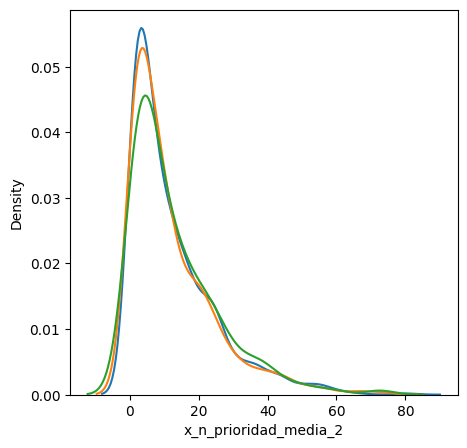

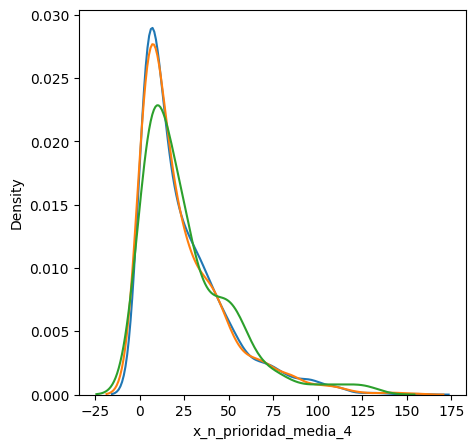

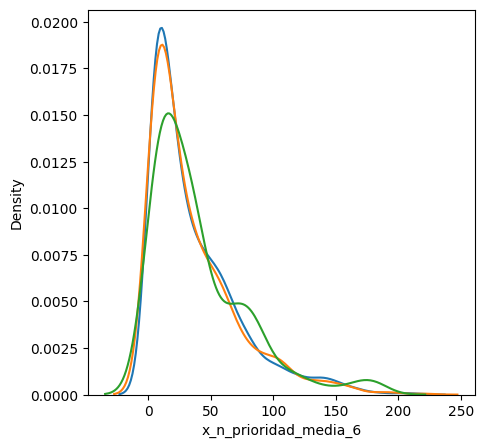

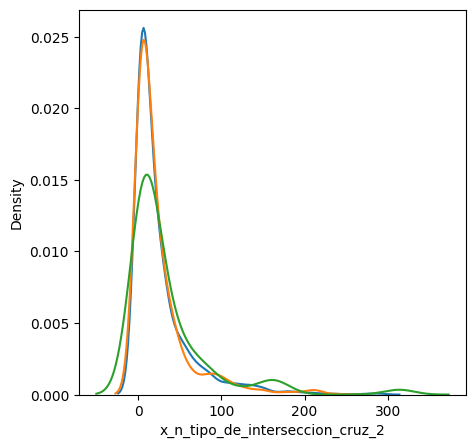

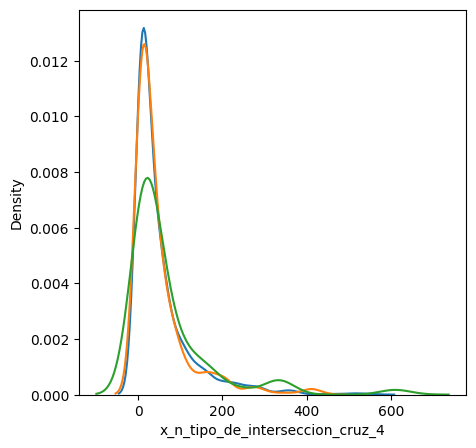

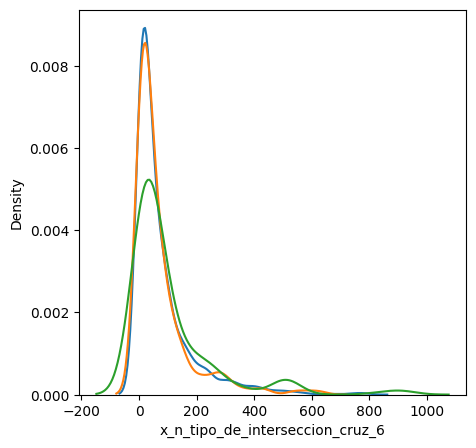

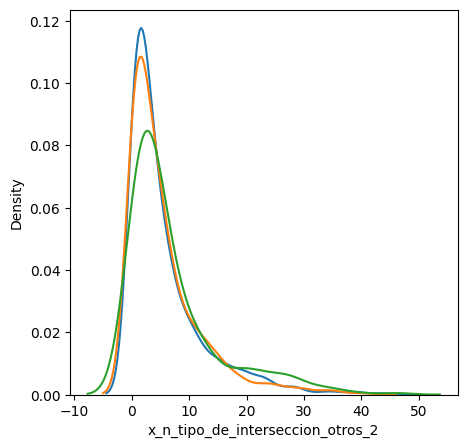

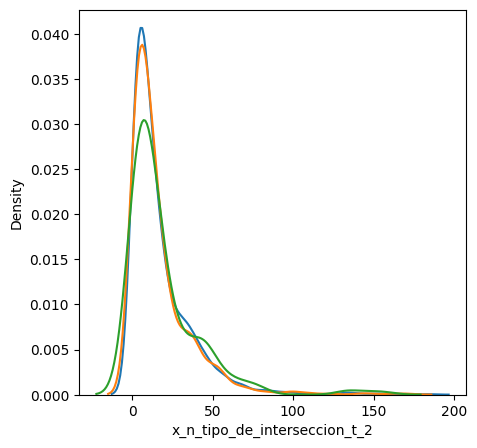

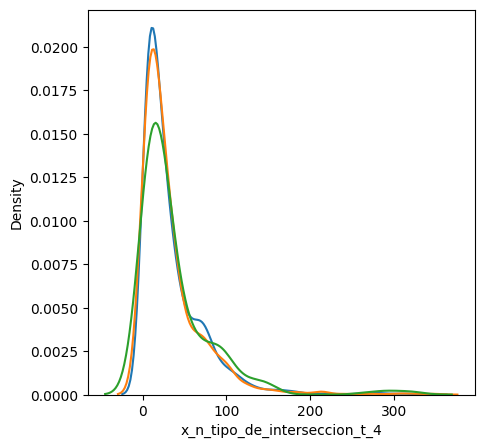

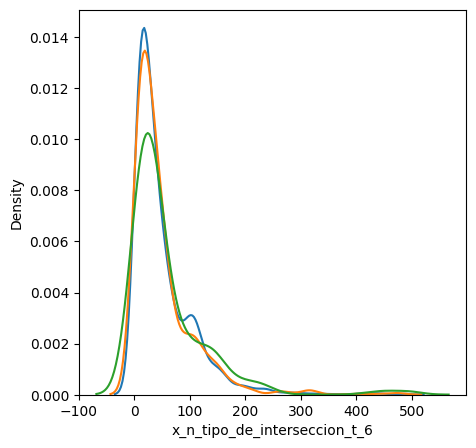

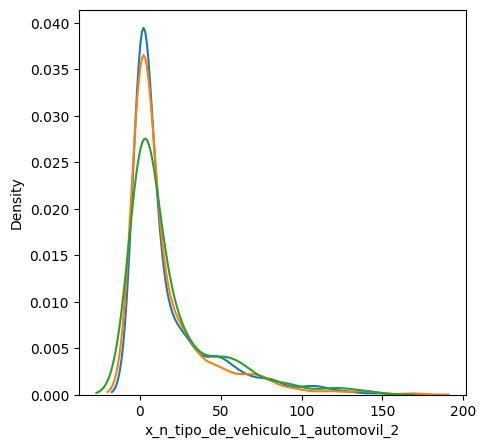

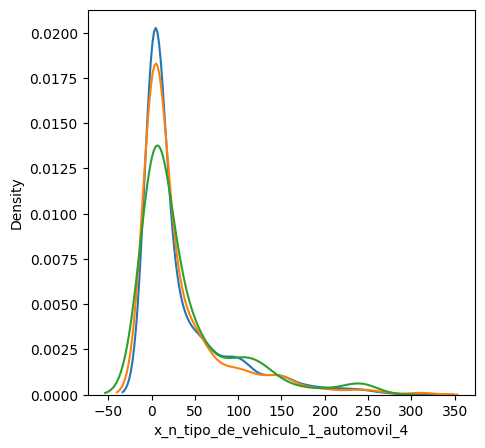

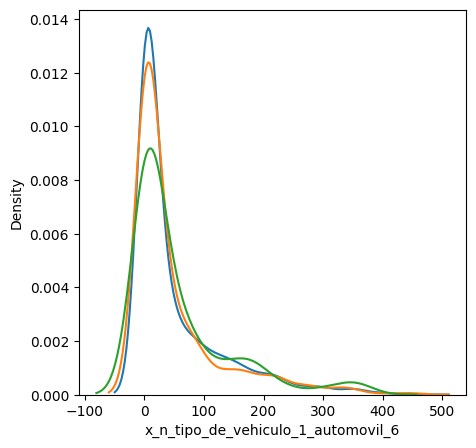

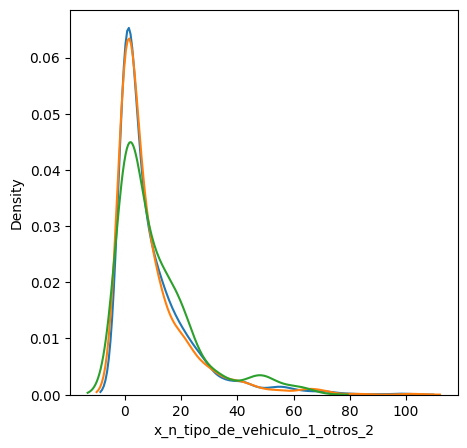

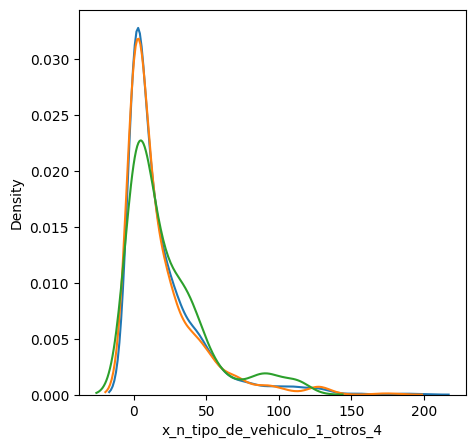

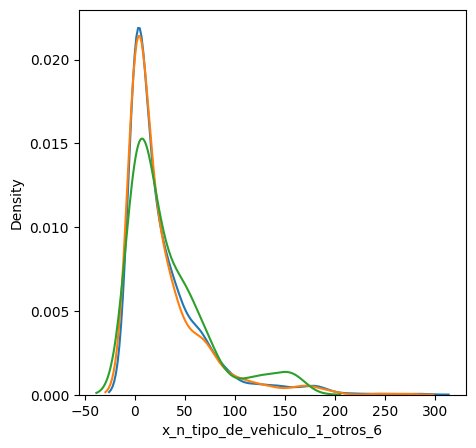

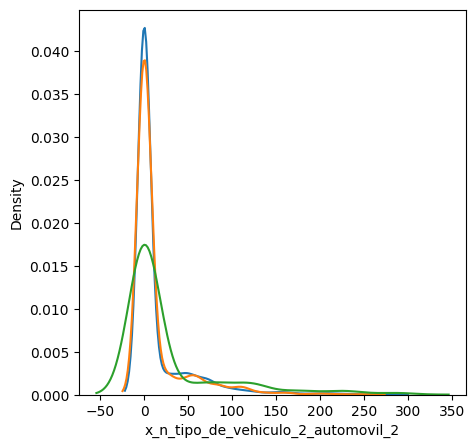

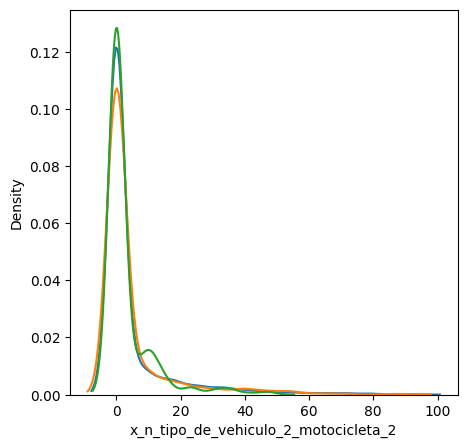

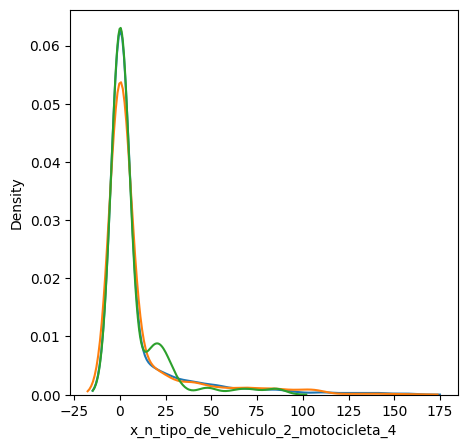

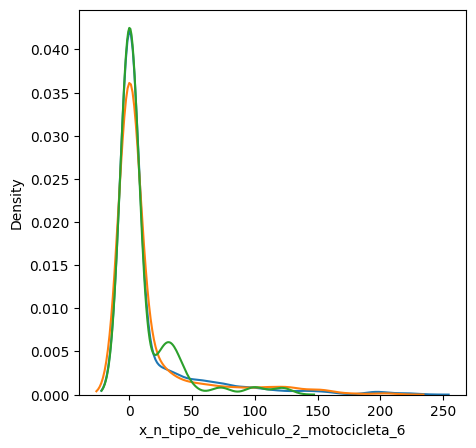

In [ ]:
for v in varc:
    plt.figure(figsize=(5,5))
    sns.kdeplot(train[v])
    sns.kdeplot(valid[v])
    sns.kdeplot(ot[v])

In [ ]:
len(varc)

20

### Ausentes

In [ ]:
miss = (train[varc].isnull().sum()/len(train)).to_frame().sort_values(by=0,ascending=False)
miss

,0
x_n_prioridad_media_2,0.0
x_n_prioridad_media_4,0.0
x_n_prioridad_media_6,0.0
x_n_tipo_de_interseccion_cruz_2,0.0
x_n_tipo_de_interseccion_cruz_4,0.0
x_n_tipo_de_interseccion_cruz_6,0.0
x_n_tipo_de_interseccion_otros_2,0.0
x_n_tipo_de_interseccion_t_2,0.0
x_n_tipo_de_interseccion_t_4,0.0
x_n_tipo_de_interseccion_t_6,0.0


### Multicolinealidad

In [ ]:
vc = VarClusHi(df=train[varc],feat_list=varc).varclus()
display(vc.rsquare)
vc = vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()
mc = list(vc['Variable'])
mc

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,x_n_prioridad_media_2,0.851808,0.602136,0.372470
1,0,x_n_prioridad_media_4,0.877094,0.632264,0.334222
2,0,x_n_prioridad_media_6,0.875345,0.635572,0.342058
3,0,x_n_tipo_de_interseccion_cruz_2,0.866774,0.563930,0.305516
4,0,x_n_tipo_de_interseccion_cruz_4,0.874968,0.577668,0.296052
5,0,x_n_tipo_de_interseccion_cruz_6,0.872529,0.591862,0.312323
6,0,x_n_tipo_de_interseccion_otros_2,0.685136,0.414764,0.538012
7,0,x_n_tipo_de_interseccion_t_2,0.813418,0.499469,0.372768
8,0,x_n_tipo_de_interseccion_t_4,0.836793,0.514620,0.336245
9,0,x_n_tipo_de_interseccion_t_6,0.838533,0.525059,0.339974


['x_n_tipo_de_interseccion_cruz_4',
 'x_n_tipo_de_vehiculo_2_motocicleta_4',
 'x_n_tipo_de_vehiculo_1_otros_4']

### Extremos

array([[<Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'x_n_tipo_de_interseccion_cruz_4'}>],
       [<Axes: title={'center': 'x_n_tipo_de_vehiculo_2_motocicleta_4'}>,
        <Axes: title={'center': 'x_n_tipo_de_vehiculo_1_otros_4'}>]],
      dtype=object)

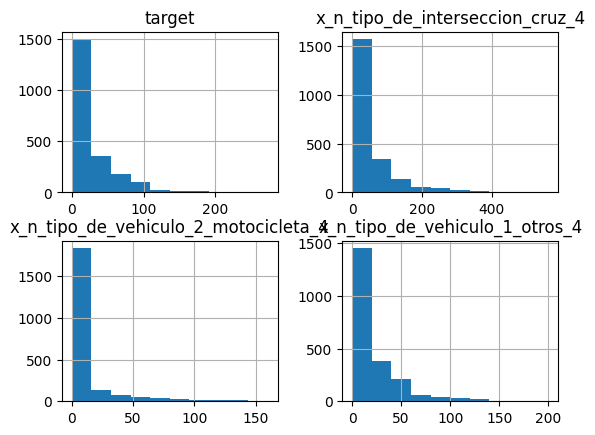

In [ ]:
train[vart+mc].hist()

ex_
0    0.966287
1    0.033713
Name: proportion, dtype: float64

(2121, 73)


array([[<Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'x_n_tipo_de_interseccion_cruz_4'}>],
       [<Axes: title={'center': 'x_n_tipo_de_vehiculo_2_motocicleta_4'}>,
        <Axes: title={'center': 'x_n_tipo_de_vehiculo_1_otros_4'}>]],
      dtype=object)

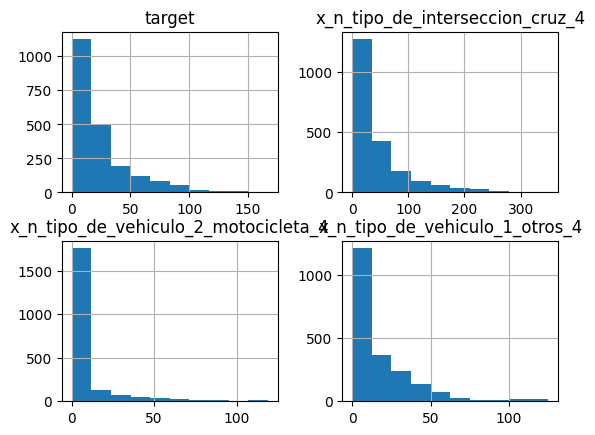

In [ ]:
for v,li,ls in train[vart+mc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').max(axis=1)
display(train['ex_'].value_counts(1))
train = train[train['ex_']==0].drop(train.filter(like='ex_').columns,axis=1).reset_index(drop=True)
print(train.shape)
train[vart+mc].hist()

### Poder predictivo

In [ ]:
sk = SelectKBest(f_regression,k=3)
sk.fit(train[mc],train[vart[0]])

SelectKBest(k=3, score_func=<function f_regression at 0x7f14b2669ea0>)

In [ ]:
pd.Series(dict(zip(mc,sk.scores_))).iplot(kind='bar',color='purple')

## Aprendizaje

### Regresion Lineal de Cresta

In [ ]:
reg = Ridge()
hyperparam = {'alpha':np.logspace(-3,3,7),
'fit_intercept':[True,False],
'solver':['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']}
print(reduce(lambda x,y:x*y,map(len,hyperparam.values())))
grid = GridSearchCV(reg,hyperparam,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
grid.fit(train[mc],train[vart[0]])
print(grid.best_params_)
print(grid.best_score_)
reg = grid.best_estimator_
reg.fit(train[mc],train[vart[0]])
print(mean_absolute_error(train[vart[0]],reg.predict(train[mc])))

98
{'alpha': 10.0, 'fit_intercept': True, 'solver': 'sag'}
-7.132426406635271
7.119903697845611


### Random Forest

In [ ]:
rf = RandomForestRegressor()
hyperparam = {'n_estimators':range(2,20),
'min_samples_leaf':np.arange(0.01,0.1,0.01),
'max_depth':range(2,20)}

print(reduce(lambda x,y:x*y,map(len,hyperparam.values())))
grid = GridSearchCV(rf,hyperparam,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
grid.fit(train[mc],train[vart[0]])
print(grid.best_params_)
print(grid.best_score_)
rf = grid.best_estimator_
rf.fit(train[mc],train[vart[0]])
print(mean_absolute_error(train[vart[0]],rf.predict(train[mc])))

2916
{'max_depth': 15, 'min_samples_leaf': 0.01, 'n_estimators': 11}
-6.650115167656648
6.333972399764569


### Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor()
hyperparam = {'n_estimators':range(2,20),
'min_samples_leaf':np.arange(0.01,0.1,0.01),
'max_depth':range(2,20)}

print(reduce(lambda x,y:x*y,map(len,hyperparam.values())))
grid = GridSearchCV(gb,hyperparam,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
grid.fit(train[mc],train[vart[0]])
print(grid.best_params_)
print(grid.best_score_)
gb = grid.best_estimator_
gb.fit(train[mc],train[vart[0]])
print(mean_absolute_error(train[vart[0]],gb.predict(train[mc])))

2916
{'max_depth': 6, 'min_samples_leaf': 0.01, 'n_estimators': 19}
-7.0116427498471
6.3531018626227596


## Generalización del Modelo

In [ ]:
print(mean_absolute_error(valid[vart[0]],gb.predict(valid[mc])))
print(mean_absolute_error(ot[vart[0]],gb.predict(ot[mc])))

7.535500390428644
13.571659334424544


In [ ]:
train['y^'] = gb.predict(train[mc])
valid['y^'] = gb.predict(valid[mc])
ot['y^'] = gb.predict(ot[mc])

<Axes: xlabel='target', ylabel='Density'>

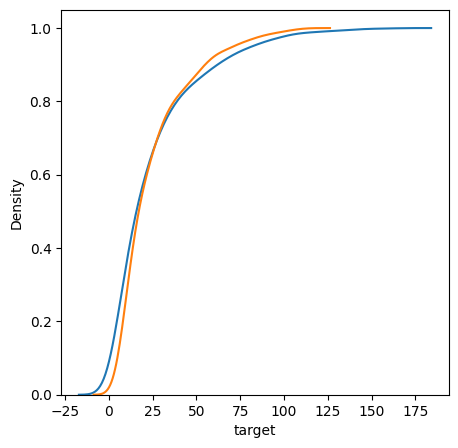

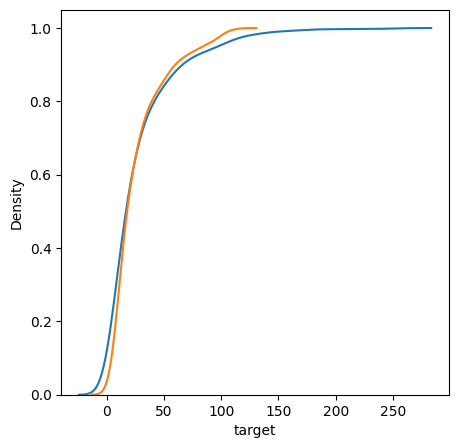

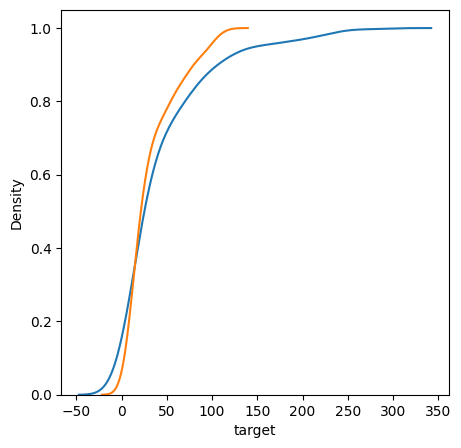

In [ ]:
plt.figure(figsize=(5,5))
sns.kdeplot(train[vart[0]],cumulative=True)
sns.kdeplot(train['y^'],cumulative=True)

plt.figure(figsize=(5,5))
sns.kdeplot(valid[vart[0]],cumulative=True)
sns.kdeplot(valid['y^'],cumulative=True)

plt.figure(figsize=(5,5))
sns.kdeplot(ot[vart[0]],cumulative=True)
sns.kdeplot(ot['y^'],cumulative=True)


In [ ]:
ot.sample(20)[um+['target','y^']]

,alcaldia,n_tipo_de_evento,ancla,target,y^
187,VENUSTIANO CARRANZA,Otros,57,7.0,10.050053
283,GUSTAVO A MADERO,Otros,59,13.0,14.425346
58,VENUSTIANO CARRANZA,DERRAPADO,55,36.0,26.595813
109,MILPA ALTA,CHOQUE,56,4.0,10.135192
186,VENUSTIANO CARRANZA,DERRAPADO,57,40.0,34.814223
215,CUAUHTEMOC,Otros,58,17.0,24.840901
264,BENITO JUAREZ,ATROPELLADO,59,29.0,25.234709
228,MAGDALENA CONTRERAS,ATROPELLADO,58,5.0,6.457861
274,CUAJIMALPA,DERRAPADO,59,9.0,5.839958
131,ALVARO OBREGON,Otros,57,3.0,8.465692


## Persistencia del modelo

In [ ]:
pickle.dump((rf,mc),open('modelo_incidentes_viales.pkl','wb'))